# LSTM-Speech Classifier
This is a notebook to train LSTM model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.autograd import Variable
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

show a waveform sample

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


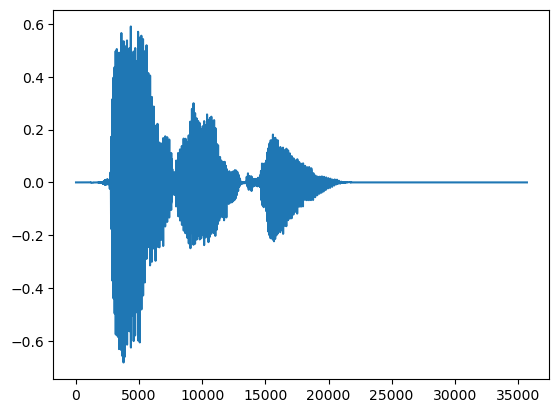

In [20]:
import os

DatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData"
waveform, sr = torchaudio.load(filepath=DatasetFilePath + "/sensitive/0.wav", frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
print(waveform)
plt.plot(waveform.t().numpy())

## Importing the dataset

In [21]:
X = []
y = []
NonDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/nonsensitive"
SenDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/sensitive"
for root, dirs, files in os.walk(SenDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(SenDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
for root, dirs, files in os.walk(NonDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(NonDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("nonsensitive")
X = X
y = y
NumberofSensitiveData = y.count('sensitive')
print('There are %d sensitive data' % NumberofSensitiveData)
print('There are %d nonsensitive data' % (len(y) - NumberofSensitiveData))

There are 487 sensitive data
There are 735 nonsensitive data


Divide dataset into training set and testing set

In [22]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
from torch.utils.data import Dataset

class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# get the size of the dataset
print(len(train_dataset))
print(len(test_dataset))


977
245


In [24]:
labels = sorted(list(set(datapoint[1] for datapoint in train_dataset)))
labels

['nonsensitive', 'sensitive']

## Formatting Data
This is a good place to apply transformations to the data. For the waveform, we downsample the audio for faster processing without losing too much of the classification power.

In [25]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [26]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "sensitive"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

sensitive --> tensor(1) --> sensitive


In [27]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 1
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)

## Create LSTM Model

In [28]:
class LSTM(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, hidden_dim=32):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2 * n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.lstm = nn.LSTM(2 * n_channel, hidden_dim)
        bidirectional_set  = True
        num_layers = 2
        input_size = 64
        hidden_size = 32
        # embedding_size = 32
        # self.embeddings = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.lstm_seq = nn.LSTM(input_size, hidden_size, num_layers=num_layers,bidirectional=bidirectional_set,batch_first=True)  # 构建LSTM网络
        # lstm_input = Variable(torch.randn(1, 1, input_size))  # 构建输入
        # h_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建h输入参数
        # c_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建c输出参数
        # out, (h, c) = lstm_seq(lstm_input, (h_init, c_init))  # 计算
        self.fc1 = nn.Linear(2 * n_channel, n_output)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        # print(x)
        # x = self.embeddings(x)
        x, (ht, ct) = self.lstm_seq(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = LSTM(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

LSTM(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 32)
  (lstm_seq): LSTM(64, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
Number of parameters: 71842


In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [30]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        #print(output.squeeze(), target)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(torch.squeeze(output, dim=0), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [31]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)
        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [32]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/977 (0%)]	Loss: 0.706334


  1%|          | 0.023731587561374806/2 [00:00<00:16,  8.20s/it]

Train Epoch: 1 [20/977 (2%)]	Loss: 0.046286


  2%|▏         | 0.03927986906710312/2 [00:00<00:14,  7.41s/it] 

Train Epoch: 1 [40/977 (4%)]	Loss: 0.768485


  3%|▎         | 0.05482815057283139/2 [00:00<00:13,  7.03s/it]

Train Epoch: 1 [60/977 (6%)]	Loss: 0.631703


  3%|▎         | 0.06955810147299503/2 [00:00<00:13,  6.96s/it]

Train Epoch: 1 [80/977 (8%)]	Loss: 0.850240


  4%|▍         | 0.08592471358428795/2 [00:00<00:12,  6.71s/it]

Train Epoch: 1 [100/977 (10%)]	Loss: 0.762772


  5%|▌         | 0.10147299509001623/2 [00:00<00:13,  6.86s/it]

Train Epoch: 1 [120/977 (12%)]	Loss: 0.592060


  6%|▌         | 0.11620294599017986/2 [00:00<00:13,  7.20s/it]

Train Epoch: 1 [140/977 (14%)]	Loss: 0.918819


  7%|▋         | 0.1309328968903436/2 [00:00<00:14,  7.55s/it] 

Train Epoch: 1 [160/977 (16%)]	Loss: 0.529042


  7%|▋         | 0.14484451718494282/2 [00:01<00:14,  7.84s/it]

Train Epoch: 1 [180/977 (18%)]	Loss: 0.536688


  9%|▊         | 0.17266775777414126/2 [00:01<00:13,  7.54s/it]

Train Epoch: 1 [200/977 (20%)]	Loss: 0.513280


  9%|▉         | 0.18739770867430514/2 [00:01<00:13,  7.42s/it]

Train Epoch: 1 [220/977 (23%)]	Loss: 0.499859


 10%|█         | 0.20130932896890436/2 [00:01<00:13,  7.55s/it]

Train Epoch: 1 [240/977 (25%)]	Loss: 0.616422


 11%|█         | 0.21522094926350357/2 [00:01<00:13,  7.44s/it]

Train Epoch: 1 [260/977 (27%)]	Loss: 0.587151


 11%|█▏        | 0.2291325695581028/2 [00:01<00:13,  7.69s/it] 

Train Epoch: 1 [280/977 (29%)]	Loss: 0.818288


 12%|█▏        | 0.24222585924713735/2 [00:01<00:15,  8.56s/it]

Train Epoch: 1 [300/977 (31%)]	Loss: 0.801197


 14%|█▎        | 0.27086743044189976/2 [00:02<00:13,  7.85s/it]

Train Epoch: 1 [320/977 (33%)]	Loss: 0.595668


 14%|█▍        | 0.28559738134206314/2 [00:02<00:12,  7.55s/it]

Train Epoch: 1 [340/977 (35%)]	Loss: 0.859326


 15%|█▌        | 0.3003273322422265/2 [00:02<00:12,  7.40s/it] 

Train Epoch: 1 [360/977 (37%)]	Loss: 0.868479


 16%|█▌        | 0.31669394435351916/2 [00:02<00:11,  6.99s/it]

Train Epoch: 1 [380/977 (39%)]	Loss: 0.570955


 17%|█▋        | 0.3322422258592472/2 [00:02<00:11,  6.86s/it] 

Train Epoch: 1 [400/977 (41%)]	Loss: 0.866085


 17%|█▋        | 0.3477905073649752/2 [00:02<00:11,  6.81s/it]

Train Epoch: 1 [420/977 (43%)]	Loss: 0.534684


 18%|█▊        | 0.3633387888707032/2 [00:02<00:11,  6.76s/it]

Train Epoch: 1 [440/977 (45%)]	Loss: 0.554276


 19%|█▉        | 0.37970540098199584/2 [00:02<00:10,  6.64s/it]

Train Epoch: 1 [460/977 (47%)]	Loss: 0.830392


 20%|█▉        | 0.39525368248772386/2 [00:02<00:10,  6.75s/it]

Train Epoch: 1 [480/977 (49%)]	Loss: 0.610641


 21%|██        | 0.41080196399345187/2 [00:03<00:11,  7.13s/it]

Train Epoch: 1 [500/977 (51%)]	Loss: 0.613829


 21%|██▏       | 0.42553191489361525/2 [00:03<00:12,  7.68s/it]

Train Epoch: 1 [520/977 (53%)]	Loss: 0.554061


 22%|██▏       | 0.439443535188214/2 [00:03<00:12,  8.05s/it]  

Train Epoch: 1 [540/977 (55%)]	Loss: 0.976351


 23%|██▎       | 0.46644844517184686/2 [00:03<00:12,  7.89s/it]

Train Epoch: 1 [560/977 (57%)]	Loss: 0.979750


 24%|██▍       | 0.48199672667757487/2 [00:03<00:11,  7.43s/it]

Train Epoch: 1 [580/977 (59%)]	Loss: 0.545050


 25%|██▍       | 0.4959083469721736/2 [00:03<00:11,  7.46s/it] 

Train Epoch: 1 [600/977 (61%)]	Loss: 0.533664


 26%|██▌       | 0.5114566284779024/2 [00:03<00:10,  7.23s/it]

Train Epoch: 1 [620/977 (63%)]	Loss: 0.528565


 26%|██▋       | 0.5261865793780668/2 [00:03<00:10,  7.15s/it]

Train Epoch: 1 [640/977 (66%)]	Loss: 0.540832


 27%|██▋       | 0.5409165302782312/2 [00:03<00:10,  7.11s/it]

Train Epoch: 1 [660/977 (68%)]	Loss: 0.959505


 28%|██▊       | 0.5556464811783955/2 [00:04<00:10,  7.52s/it]

Train Epoch: 1 [680/977 (70%)]	Loss: 1.043895


 28%|██▊       | 0.5695581014729952/2 [00:04<00:11,  8.30s/it]

Train Epoch: 1 [700/977 (72%)]	Loss: 0.455122


 30%|██▉       | 0.5998363338788887/2 [00:04<00:10,  7.47s/it]

Train Epoch: 1 [720/977 (74%)]	Loss: 0.474234


 31%|███       | 0.6153846153846178/2 [00:04<00:10,  7.23s/it]

Train Epoch: 1 [740/977 (76%)]	Loss: 0.482207


 32%|███▏      | 0.6309328968903468/2 [00:04<00:09,  7.06s/it]

Train Epoch: 1 [760/977 (78%)]	Loss: 0.487443


 32%|███▏      | 0.6456628477905112/2 [00:04<00:09,  7.04s/it]

Train Epoch: 1 [780/977 (80%)]	Loss: 0.933010


 33%|███▎      | 0.6612111292962403/2 [00:04<00:09,  6.91s/it]

Train Epoch: 1 [800/977 (82%)]	Loss: 0.792275


 34%|███▍      | 0.6759410801964046/2 [00:04<00:09,  7.03s/it]

Train Epoch: 1 [820/977 (84%)]	Loss: 0.597877


 35%|███▍      | 0.690671031096569/2 [00:05<00:09,  7.05s/it] 

Train Epoch: 1 [840/977 (86%)]	Loss: 0.835200


 35%|███▌      | 0.7054009819967334/2 [00:05<00:09,  7.14s/it]

Train Epoch: 1 [860/977 (88%)]	Loss: 0.527313


 36%|███▌      | 0.7209492635024625/2 [00:05<00:08,  6.96s/it]

Train Epoch: 1 [880/977 (90%)]	Loss: 0.554272


 37%|███▋      | 0.7356792144026268/2 [00:05<00:08,  6.94s/it]

Train Epoch: 1 [900/977 (92%)]	Loss: 0.522931


 38%|███▊      | 0.766775777414085/2 [00:05<00:08,  6.76s/it] 

Train Epoch: 1 [920/977 (94%)]	Loss: 0.540379


 39%|███▉      | 0.782324058919814/2 [00:05<00:08,  6.94s/it]

Train Epoch: 1 [940/977 (96%)]	Loss: 0.530701
Train Epoch: 1 [960/977 (98%)]	Loss: 0.915115


 42%|████▏     | 0.8314238952536953/2 [00:05<00:05,  5.07s/it]


Test Epoch: 1	Accuracy: 1/245 (0%)


Test Epoch: 1	Accuracy: 2/245 (1%)


Test Epoch: 1	Accuracy: 3/245 (1%)


Test Epoch: 1	Accuracy: 3/245 (1%)


Test Epoch: 1	Accuracy: 3/245 (1%)


Test Epoch: 1	Accuracy: 3/245 (1%)


Test Epoch: 1	Accuracy: 4/245 (2%)


Test Epoch: 1	Accuracy: 5/245 (2%)


Test Epoch: 1	Accuracy: 6/245 (2%)


Test Epoch: 1	Accuracy: 7/245 (3%)


Test Epoch: 1	Accuracy: 8/245 (3%)


Test Epoch: 1	Accuracy: 8/245 (3%)


Test Epoch: 1	Accuracy: 9/245 (4%)


Test Epoch: 1	Accuracy: 10/245 (4%)


Test Epoch: 1	Accuracy: 11/245 (4%)


Test Epoch: 1	Accuracy: 12/245 (5%)


Test Epoch: 1	Accuracy: 12/245 (5%)


Test Epoch: 1	Accuracy: 13/245 (5%)


Test Epoch: 1	Accuracy: 14/245 (6%)


Test Epoch: 1	Accuracy: 15/245 (6%)


Test Epoch: 1	Accuracy: 16/245 (7%)


Test Epoch: 1	Accuracy: 17/245 (7%)


Test Epoch: 1	Accuracy: 18/245 (7%)


Test Epoch: 1	Accuracy: 19/245 (8%)


Test Epoch: 1	Accuracy: 20/245 (8%)


Test Epoch: 1	Accuracy: 20/245 (8%)


Test Epoch: 1	Accuracy: 

 43%|████▎     | 0.8641571194762828/2 [00:06<00:04,  4.31s/it]


Test Epoch: 1	Accuracy: 35/245 (14%)


Test Epoch: 1	Accuracy: 36/245 (15%)


Test Epoch: 1	Accuracy: 36/245 (15%)


Test Epoch: 1	Accuracy: 37/245 (15%)


Test Epoch: 1	Accuracy: 37/245 (15%)


Test Epoch: 1	Accuracy: 37/245 (15%)


Test Epoch: 1	Accuracy: 38/245 (16%)


Test Epoch: 1	Accuracy: 38/245 (16%)


Test Epoch: 1	Accuracy: 39/245 (16%)


Test Epoch: 1	Accuracy: 39/245 (16%)


Test Epoch: 1	Accuracy: 40/245 (16%)


Test Epoch: 1	Accuracy: 41/245 (17%)


Test Epoch: 1	Accuracy: 41/245 (17%)


Test Epoch: 1	Accuracy: 41/245 (17%)


Test Epoch: 1	Accuracy: 42/245 (17%)


Test Epoch: 1	Accuracy: 43/245 (18%)


Test Epoch: 1	Accuracy: 43/245 (18%)


Test Epoch: 1	Accuracy: 44/245 (18%)


Test Epoch: 1	Accuracy: 45/245 (18%)


Test Epoch: 1	Accuracy: 46/245 (19%)


Test Epoch: 1	Accuracy: 47/245 (19%)


Test Epoch: 1	Accuracy: 48/245 (20%)


Test Epoch: 1	Accuracy: 48/245 (20%)


Test Epoch: 1	Accuracy: 48/245 (20%)


Test Epoch: 1	Accuracy: 48/245 (20%)


Test Epoch: 1	Accuracy: 

 45%|████▌     | 0.9018003273322585/2 [00:06<00:04,  3.67s/it]


Test Epoch: 1	Accuracy: 55/245 (22%)


Test Epoch: 1	Accuracy: 55/245 (22%)


Test Epoch: 1	Accuracy: 56/245 (23%)


Test Epoch: 1	Accuracy: 57/245 (23%)


Test Epoch: 1	Accuracy: 58/245 (24%)


Test Epoch: 1	Accuracy: 59/245 (24%)


Test Epoch: 1	Accuracy: 59/245 (24%)


Test Epoch: 1	Accuracy: 60/245 (24%)


Test Epoch: 1	Accuracy: 60/245 (24%)


Test Epoch: 1	Accuracy: 61/245 (25%)


Test Epoch: 1	Accuracy: 62/245 (25%)


Test Epoch: 1	Accuracy: 62/245 (25%)


Test Epoch: 1	Accuracy: 63/245 (26%)


Test Epoch: 1	Accuracy: 64/245 (26%)


Test Epoch: 1	Accuracy: 64/245 (26%)


Test Epoch: 1	Accuracy: 64/245 (26%)


Test Epoch: 1	Accuracy: 64/245 (26%)


Test Epoch: 1	Accuracy: 64/245 (26%)


Test Epoch: 1	Accuracy: 65/245 (27%)


Test Epoch: 1	Accuracy: 66/245 (27%)


Test Epoch: 1	Accuracy: 67/245 (27%)


Test Epoch: 1	Accuracy: 68/245 (28%)


Test Epoch: 1	Accuracy: 69/245 (28%)


Test Epoch: 1	Accuracy: 70/245 (29%)


Test Epoch: 1	Accuracy: 71/245 (29%)


Test Epoch: 1	Accuracy: 

 47%|████▋     | 0.9353518821604107/2 [00:06<00:03,  3.46s/it]


Test Epoch: 1	Accuracy: 81/245 (33%)


Test Epoch: 1	Accuracy: 81/245 (33%)


Test Epoch: 1	Accuracy: 82/245 (33%)


Test Epoch: 1	Accuracy: 82/245 (33%)


Test Epoch: 1	Accuracy: 82/245 (33%)


Test Epoch: 1	Accuracy: 83/245 (34%)


Test Epoch: 1	Accuracy: 84/245 (34%)


Test Epoch: 1	Accuracy: 84/245 (34%)


Test Epoch: 1	Accuracy: 85/245 (35%)


Test Epoch: 1	Accuracy: 85/245 (35%)


Test Epoch: 1	Accuracy: 85/245 (35%)


Test Epoch: 1	Accuracy: 86/245 (35%)


Test Epoch: 1	Accuracy: 87/245 (36%)


Test Epoch: 1	Accuracy: 88/245 (36%)


Test Epoch: 1	Accuracy: 89/245 (36%)


Test Epoch: 1	Accuracy: 90/245 (37%)


Test Epoch: 1	Accuracy: 91/245 (37%)


Test Epoch: 1	Accuracy: 92/245 (38%)


Test Epoch: 1	Accuracy: 92/245 (38%)


Test Epoch: 1	Accuracy: 92/245 (38%)


Test Epoch: 1	Accuracy: 93/245 (38%)


Test Epoch: 1	Accuracy: 94/245 (38%)


Test Epoch: 1	Accuracy: 95/245 (39%)


Test Epoch: 1	Accuracy: 96/245 (39%)


Test Epoch: 1	Accuracy: 97/245 (40%)


Test Epoch: 1	Accuracy: 

 49%|████▊     | 0.9713584288052569/2 [00:06<00:03,  3.23s/it]


Test Epoch: 1	Accuracy: 106/245 (43%)


Test Epoch: 1	Accuracy: 107/245 (44%)


Test Epoch: 1	Accuracy: 108/245 (44%)


Test Epoch: 1	Accuracy: 109/245 (44%)


Test Epoch: 1	Accuracy: 109/245 (44%)


Test Epoch: 1	Accuracy: 109/245 (44%)


Test Epoch: 1	Accuracy: 110/245 (45%)


Test Epoch: 1	Accuracy: 110/245 (45%)


Test Epoch: 1	Accuracy: 111/245 (45%)


Test Epoch: 1	Accuracy: 112/245 (46%)


Test Epoch: 1	Accuracy: 113/245 (46%)


Test Epoch: 1	Accuracy: 113/245 (46%)


Test Epoch: 1	Accuracy: 113/245 (46%)


Test Epoch: 1	Accuracy: 114/245 (47%)


Test Epoch: 1	Accuracy: 114/245 (47%)


Test Epoch: 1	Accuracy: 115/245 (47%)


Test Epoch: 1	Accuracy: 115/245 (47%)


Test Epoch: 1	Accuracy: 116/245 (47%)


Test Epoch: 1	Accuracy: 117/245 (48%)


Test Epoch: 1	Accuracy: 118/245 (48%)


Test Epoch: 1	Accuracy: 119/245 (49%)


Test Epoch: 1	Accuracy: 120/245 (49%)


Test Epoch: 1	Accuracy: 120/245 (49%)


Test Epoch: 1	Accuracy: 121/245 (49%)


Test Epoch: 1	Accuracy: 121/245 (49%)



 50%|█████     | 1.0032733224222796/2 [00:06<00:03,  3.31s/it]


Test Epoch: 1	Accuracy: 136/245 (56%)


Test Epoch: 1	Accuracy: 136/245 (56%)


Test Epoch: 1	Accuracy: 137/245 (56%)


Test Epoch: 1	Accuracy: 138/245 (56%)


Test Epoch: 1	Accuracy: 139/245 (57%)


Test Epoch: 1	Accuracy: 140/245 (57%)


Test Epoch: 1	Accuracy: 141/245 (58%)


Test Epoch: 1	Accuracy: 142/245 (58%)


Test Epoch: 1	Accuracy: 143/245 (58%)


Test Epoch: 1	Accuracy: 143/245 (58%)


Test Epoch: 1	Accuracy: 143/245 (58%)


Test Epoch: 1	Accuracy: 143/245 (58%)


Test Epoch: 1	Accuracy: 144/245 (59%)


Test Epoch: 1	Accuracy: 145/245 (59%)


Test Epoch: 1	Accuracy: 146/245 (60%)


Test Epoch: 1	Accuracy: 146/245 (60%)


Test Epoch: 1	Accuracy: 147/245 (60%)


Test Epoch: 1	Accuracy: 148/245 (60%)


Test Epoch: 1	Accuracy: 149/245 (61%)


Test Epoch: 1	Accuracy: 150/245 (61%)


Test Epoch: 1	Accuracy: 150/245 (61%)


Test Epoch: 1	Accuracy: 151/245 (62%)


Test Epoch: 1	Accuracy: 152/245 (62%)


Test Epoch: 1	Accuracy: 152/245 (62%)


Test Epoch: 1	Accuracy: 152/245 (62%)



 52%|█████▏    | 1.0343698854337378/2 [00:06<00:04,  4.42s/it]

Train Epoch: 2 [40/977 (4%)]	Loss: 0.577245


 53%|█████▎    | 1.0605564648118078/2 [00:06<00:04,  4.92s/it]

Train Epoch: 2 [60/977 (6%)]	Loss: 0.598031
Train Epoch: 2 [80/977 (8%)]	Loss: 0.542953


 54%|█████▍    | 1.083469721767619/2 [00:07<00:04,  5.39s/it] 

Train Epoch: 2 [100/977 (10%)]	Loss: 0.526379


 55%|█████▌    | 1.1039279869067362/2 [00:07<00:04,  5.53s/it]

Train Epoch: 2 [120/977 (12%)]	Loss: 0.489984


 56%|█████▌    | 1.1235679214402887/2 [00:07<00:05,  5.85s/it]

Train Epoch: 2 [140/977 (14%)]	Loss: 0.469374


 57%|█████▋    | 1.1415711947627118/2 [00:07<00:05,  5.93s/it]

Train Epoch: 2 [160/977 (16%)]	Loss: 0.997504


 58%|█████▊    | 1.159574468085135/2 [00:07<00:05,  6.08s/it] 

Train Epoch: 2 [180/977 (18%)]	Loss: 0.882141


 59%|█████▉    | 1.1767594108019934/2 [00:07<00:05,  6.18s/it]

Train Epoch: 2 [200/977 (20%)]	Loss: 0.833965


 60%|█████▉    | 1.1931260229132872/2 [00:07<00:05,  6.27s/it]

Train Epoch: 2 [220/977 (23%)]	Loss: 0.551078


 60%|██████    | 1.209492635024581/2 [00:07<00:04,  6.24s/it] 

Train Epoch: 2 [240/977 (25%)]	Loss: 0.509347


 61%|██████▏   | 1.2258592471358747/2 [00:07<00:04,  6.31s/it]

Train Epoch: 2 [260/977 (27%)]	Loss: 0.535669


 62%|██████▏   | 1.2422258592471684/2 [00:08<00:04,  6.31s/it]

Train Epoch: 2 [280/977 (29%)]	Loss: 0.534949


 63%|██████▎   | 1.2585924713584622/2 [00:08<00:04,  6.54s/it]

Train Epoch: 2 [300/977 (31%)]	Loss: 0.509434


 64%|██████▍   | 1.2757774140753206/2 [00:08<00:04,  6.40s/it]

Train Epoch: 2 [320/977 (33%)]	Loss: 0.515175


 65%|██████▍   | 1.2921440261866144/2 [00:08<00:04,  6.45s/it]

Train Epoch: 2 [340/977 (35%)]	Loss: 0.530327


 65%|██████▌   | 1.3085106382979081/2 [00:08<00:04,  6.37s/it]

Train Epoch: 2 [360/977 (37%)]	Loss: 0.494579


 66%|██████▌   | 1.324877250409202/2 [00:08<00:04,  6.41s/it] 

Train Epoch: 2 [380/977 (39%)]	Loss: 0.343635


 67%|██████▋   | 1.3412438625204957/2 [00:08<00:04,  6.56s/it]

Train Epoch: 2 [400/977 (41%)]	Loss: 1.252896


 68%|██████▊   | 1.3576104746317894/2 [00:08<00:04,  6.47s/it]

Train Epoch: 2 [420/977 (43%)]	Loss: 0.994304


 69%|██████▊   | 1.3731587561375185/2 [00:08<00:04,  6.55s/it]

Train Epoch: 2 [440/977 (45%)]	Loss: 2.507015


 69%|██████▉   | 1.3895253682488122/2 [00:08<00:03,  6.51s/it]

Train Epoch: 2 [460/977 (47%)]	Loss: 0.452816


 70%|███████   | 1.4050736497545413/2 [00:09<00:03,  6.59s/it]

Train Epoch: 2 [480/977 (49%)]	Loss: 0.967357


 71%|███████   | 1.4206219312602704/2 [00:09<00:04,  6.93s/it]

Train Epoch: 2 [500/977 (51%)]	Loss: 0.907143


 72%|███████▏  | 1.4353518821604347/2 [00:09<00:03,  6.94s/it]

Train Epoch: 2 [520/977 (53%)]	Loss: 0.722282


 73%|███████▎  | 1.4517184942717285/2 [00:09<00:03,  6.75s/it]

Train Epoch: 2 [540/977 (55%)]	Loss: 0.522979


 73%|███████▎  | 1.4672667757774576/2 [00:09<00:03,  6.71s/it]

Train Epoch: 2 [560/977 (57%)]	Loss: 0.530388


 74%|███████▍  | 1.4828150572831866/2 [00:09<00:03,  6.79s/it]

Train Epoch: 2 [580/977 (59%)]	Loss: 0.828933


 75%|███████▍  | 1.4983633387889157/2 [00:09<00:03,  6.79s/it]

Train Epoch: 2 [600/977 (61%)]	Loss: 0.858429


 76%|███████▌  | 1.5155482815057741/2 [00:09<00:03,  6.51s/it]

Train Epoch: 2 [620/977 (63%)]	Loss: 0.650076


 77%|███████▋  | 1.531914893617068/2 [00:09<00:03,  6.42s/it] 

Train Epoch: 2 [640/977 (66%)]	Loss: 0.332906


 77%|███████▋  | 1.5482815057283617/2 [00:10<00:02,  6.56s/it]

Train Epoch: 2 [660/977 (68%)]	Loss: 1.521232


 78%|███████▊  | 1.5646481178396554/2 [00:10<00:02,  6.48s/it]

Train Epoch: 2 [680/977 (70%)]	Loss: 0.971266


 79%|███████▉  | 1.5810147299509492/2 [00:10<00:02,  6.50s/it]

Train Epoch: 2 [700/977 (72%)]	Loss: 0.960214


 80%|███████▉  | 1.5965630114566782/2 [00:10<00:02,  6.57s/it]

Train Epoch: 2 [720/977 (74%)]	Loss: 0.946448


 81%|████████  | 1.6121112929624073/2 [00:10<00:02,  6.62s/it]

Train Epoch: 2 [740/977 (76%)]	Loss: 0.515585


 81%|████████▏ | 1.6292962356792657/2 [00:10<00:02,  6.46s/it]

Train Epoch: 2 [760/977 (78%)]	Loss: 0.552632


 82%|████████▏ | 1.6448445171849948/2 [00:10<00:02,  6.50s/it]

Train Epoch: 2 [780/977 (80%)]	Loss: 0.584489


 83%|████████▎ | 1.6612111292962886/2 [00:10<00:02,  6.41s/it]

Train Epoch: 2 [800/977 (82%)]	Loss: 0.611542


 84%|████████▍ | 1.6775777414075823/2 [00:10<00:02,  6.56s/it]

Train Epoch: 2 [820/977 (84%)]	Loss: 0.716512


 85%|████████▍ | 1.6931260229133114/2 [00:11<00:02,  6.81s/it]

Train Epoch: 2 [840/977 (86%)]	Loss: 0.680048


 85%|████████▌ | 1.7078559738134758/2 [00:11<00:02,  6.99s/it]

Train Epoch: 2 [860/977 (88%)]	Loss: 0.649067


 86%|████████▌ | 1.7225859247136401/2 [00:11<00:01,  7.00s/it]

Train Epoch: 2 [880/977 (90%)]	Loss: 0.589150


 87%|████████▋ | 1.7373158756138045/2 [00:11<00:01,  7.52s/it]

Train Epoch: 2 [900/977 (92%)]	Loss: 0.932178


 88%|████████▊ | 1.7512274959084042/2 [00:11<00:01,  7.46s/it]

Train Epoch: 2 [920/977 (94%)]	Loss: 0.907513


 89%|████████▉ | 1.7847790507365564/2 [00:11<00:01,  6.73s/it]

Train Epoch: 2 [940/977 (96%)]	Loss: 0.904050
Train Epoch: 2 [960/977 (98%)]	Loss: 0.505152


 90%|█████████ | 1.8003273322422855/2 [00:11<00:01,  6.70s/it]


Test Epoch: 2	Accuracy: 1/245 (0%)


Test Epoch: 2	Accuracy: 2/245 (1%)



 93%|█████████▎| 1.8690671031097192/2 [00:11<00:00,  4.06s/it]


Test Epoch: 2	Accuracy: 3/245 (1%)


Test Epoch: 2	Accuracy: 3/245 (1%)


Test Epoch: 2	Accuracy: 3/245 (1%)


Test Epoch: 2	Accuracy: 3/245 (1%)


Test Epoch: 2	Accuracy: 4/245 (2%)


Test Epoch: 2	Accuracy: 5/245 (2%)


Test Epoch: 2	Accuracy: 6/245 (2%)


Test Epoch: 2	Accuracy: 7/245 (3%)


Test Epoch: 2	Accuracy: 8/245 (3%)


Test Epoch: 2	Accuracy: 8/245 (3%)


Test Epoch: 2	Accuracy: 9/245 (4%)


Test Epoch: 2	Accuracy: 10/245 (4%)


Test Epoch: 2	Accuracy: 11/245 (4%)


Test Epoch: 2	Accuracy: 12/245 (5%)


Test Epoch: 2	Accuracy: 12/245 (5%)


Test Epoch: 2	Accuracy: 13/245 (5%)


Test Epoch: 2	Accuracy: 14/245 (6%)


Test Epoch: 2	Accuracy: 15/245 (6%)


Test Epoch: 2	Accuracy: 16/245 (7%)


Test Epoch: 2	Accuracy: 17/245 (7%)


Test Epoch: 2	Accuracy: 18/245 (7%)


Test Epoch: 2	Accuracy: 19/245 (8%)


Test Epoch: 2	Accuracy: 20/245 (8%)


Test Epoch: 2	Accuracy: 20/245 (8%)


Test Epoch: 2	Accuracy: 21/245 (9%)


Test Epoch: 2	Accuracy: 22/245 (9%)


Test Epoch: 2	Accuracy

 97%|█████████▋| 1.940261865793847/2 [00:12<00:00,  3.35s/it] 


Test Epoch: 2	Accuracy: 59/245 (24%)


Test Epoch: 2	Accuracy: 60/245 (24%)


Test Epoch: 2	Accuracy: 60/245 (24%)


Test Epoch: 2	Accuracy: 61/245 (25%)


Test Epoch: 2	Accuracy: 62/245 (25%)


Test Epoch: 2	Accuracy: 62/245 (25%)


Test Epoch: 2	Accuracy: 63/245 (26%)


Test Epoch: 2	Accuracy: 64/245 (26%)


Test Epoch: 2	Accuracy: 64/245 (26%)


Test Epoch: 2	Accuracy: 64/245 (26%)


Test Epoch: 2	Accuracy: 64/245 (26%)


Test Epoch: 2	Accuracy: 64/245 (26%)


Test Epoch: 2	Accuracy: 65/245 (27%)


Test Epoch: 2	Accuracy: 66/245 (27%)


Test Epoch: 2	Accuracy: 67/245 (27%)


Test Epoch: 2	Accuracy: 68/245 (28%)


Test Epoch: 2	Accuracy: 69/245 (28%)


Test Epoch: 2	Accuracy: 70/245 (29%)


Test Epoch: 2	Accuracy: 71/245 (29%)


Test Epoch: 2	Accuracy: 71/245 (29%)


Test Epoch: 2	Accuracy: 72/245 (29%)


Test Epoch: 2	Accuracy: 72/245 (29%)


Test Epoch: 2	Accuracy: 72/245 (29%)


Test Epoch: 2	Accuracy: 72/245 (29%)


Test Epoch: 2	Accuracy: 73/245 (30%)


Test Epoch: 2	Accuracy: 

 99%|█████████▉| 1.977086743044258/2 [00:12<00:00,  3.14s/it]/Users/xuhuan/opt/anaconda3/envs/python37/lib/python3.7/site-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 2.0000000000000693/2 [00:12<00:00,  6.16s/it]


Test Epoch: 2	Accuracy: 111/245 (45%)


Test Epoch: 2	Accuracy: 112/245 (46%)


Test Epoch: 2	Accuracy: 113/245 (46%)


Test Epoch: 2	Accuracy: 113/245 (46%)


Test Epoch: 2	Accuracy: 113/245 (46%)


Test Epoch: 2	Accuracy: 114/245 (47%)


Test Epoch: 2	Accuracy: 114/245 (47%)


Test Epoch: 2	Accuracy: 115/245 (47%)


Test Epoch: 2	Accuracy: 115/245 (47%)


Test Epoch: 2	Accuracy: 116/245 (47%)


Test Epoch: 2	Accuracy: 117/245 (48%)


Test Epoch: 2	Accuracy: 118/245 (48%)


Test Epoch: 2	Accuracy: 119/245 (49%)


Test Epoch: 2	Accuracy: 120/245 (49%)


Test Epoch: 2	Accuracy: 120/245 (49%)


Test Epoch: 2	Accuracy: 121/245 (49%)


Test Epoch: 2	Accuracy: 121/245 (49%)


Test Epoch: 2	Accuracy: 122/245 (50%)


Test Epoch: 2	Accuracy: 122/245 (50%)


Test Epoch: 2	Accuracy: 122/245 (50%)


Test Epoch: 2	Accuracy: 123/245 (50%)


Test Epoch: 2	Accuracy: 124/245 (51%)


Test Epoch: 2	Accuracy: 125/245 (51%)


Test Epoch: 2	Accuracy: 125/245 (51%)


Test Epoch: 2	Accuracy: 126/245 (51%)



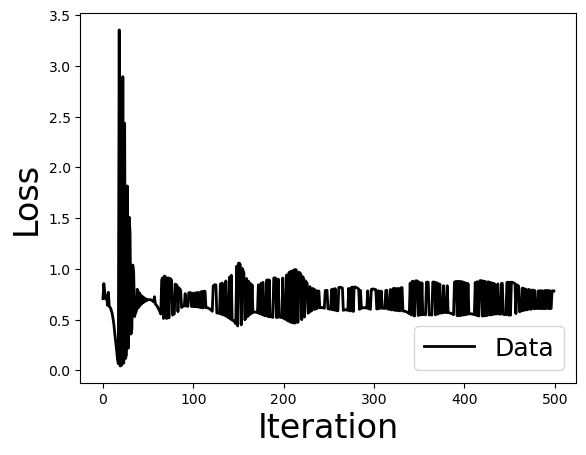

In [33]:
loss=losses[0:500]
plt.plot(range(len(loss)), loss, 'k-', label='Data', linewidth=2)
font1 = {'size': 18}
plt.legend(loc=4, prop=font1)
plt.xlabel(u'Iteration', size=24)
plt.ylabel(u'Loss', size=24)
plt.show()
